# Concours MTH3302
#### Polytechnique Montréal
### Projet A2024
----
### Objectif
Prédire **la `consommation` en carburant de voitures récentes**.

### Données
Le jeu de données contient pour presque 400 véhicule, la consommation moyenne en L/100km, l'année de frabrication, le type de véhicule, le nombre de cylindre, cylindree, la transmission et la boite.

- `train.csv` est l'ensemble d'entraînement
- `test.csv` est l'ensemble de test


## Chargement des données

Importation des librairies utilisées dans le calepin.

In [1]:
using CSV, DataFrames, Statistics, Dates, Gadfly, Combinatorics, Random, LinearAlgebra,  DecisionTree

Le premier fichier est l'ensemble des données pour l'entrainement, il contient l'année, le type, le nombre_cylindres, la cylindree, la transmission, la boite, la consommation.

Étant donné que les colonnes `cylindree` et `consommation` sont actuellement définies comme `String3` et `String31` respectivement, il est nécessaire de modifier leur type en `Float64` dans les deux ensembles de données afin de pouvoir les analyser correctement.

Afin de simplifier la manipulation des données lors de la prédiction, une colonne `id` a été ajoutée à l'ensemble des données. Cette colonne attribue un identifiant unique à chaque ligne de l’ensemble des données.

In [2]:
train_data = CSV.read("./data/train.csv", DataFrame)
train_data.consommation = parse.(Float64,replace.(train_data.consommation, "," => "."))
train_data.cylindree = parse.(Float64,replace.(train_data.cylindree, "," => "."))
train_data[!, :id] = 1:nrow(train_data)
first(train_data, 1)

1×8 DataFrame
 Row │ annee  type             nombre_cylindres  cylindree  transmission  boit ⋯
     │ Int64  String31         Int64             Float64    String15      Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                 8        4.4  integrale     auto ⋯
                                                               3 columns omitted

Le deuxième fichier est l'ensemble des données pour le test, il contient l'année, le type, le nombre_cylindres, la cylindree, la transmission, la boite. La consommation est absente dans ce fichier, car il s'agit de la variable d'intérêt.

In [3]:
test_data = CSV.read("./data/test.csv", DataFrame)
test_data.cylindree = parse.(Float64,replace.(test_data.cylindree, "," => "."))
test_data[!, :id] = 1:nrow(test_data)
first(test_data, 1)

1×7 DataFrame
 Row │ annee  type             nombre_cylindres  cylindree  transmission  boit ⋯
     │ Int64  String31         Int64             Float64    String15      Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2014  voiture_moyenne                 4        2.5  traction      manu ⋯
                                                               2 columns omitted

## Exploration des données

Lors de l’étape d’exploration des données, notre objectif principal était de mieux comprendre les caractéristiques disponibles afin d’évaluer leur pertinence pour la prédiction de la `consommation` en carburant. Nous avons adopté une approche intuitive, en nous appuyant sur nos connaissances de base concernant les véhicules et leur consommation, pour repérer les tendances et des relations potentielles entre les variables.

#### Données pour l'exploration

Effectuons une copie des données pour l'exploration en retirant l'`id` car il est inutile dans ce contexte.

In [4]:
train_data_exploration = deepcopy(train_data)
select!(train_data_exploration, Not(:id))
test_data_exploration = deepcopy(test_data)
first(train_data_exploration, 1)

1×7 DataFrame
 Row │ annee  type             nombre_cylindres  cylindree  transmission  boit ⋯
     │ Int64  String31         Int64             Float64    String15      Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                 8        4.4  integrale     auto ⋯
                                                               2 columns omitted

### Données manquantes

Vérifions s'il y a des données manquantes dans l'ensemble d'entraînement et dans l'ensemble de test.

In [5]:
function missing_data(data)
    return  mapcols(x -> sum(ismissing.(x)), data)
end

missing_data (generic function with 1 method)

In [6]:
missing_data(train_data_exploration)

1×7 DataFrame
 Row │ annee  type   nombre_cylindres  cylindree  transmission  boite  consomm ⋯
     │ Int64  Int64  Int64             Int64      Int64         Int64  Int64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │     0      0                 0          0             0      0          ⋯
                                                                1 column omitted

In [7]:
missing_data(test_data_exploration)

1×7 DataFrame
 Row │ annee  type   nombre_cylindres  cylindree  transmission  boite  id    
     │ Int64  Int64  Int64             Int64      Int64         Int64  Int64 
─────┼───────────────────────────────────────────────────────────────────────
   1 │     0      0                 0          0             0      0      0

Nous pouvons constater qu'il n'y a pas de donnée manquante dans les données fournies.

### Création de nouvelles variables explicatives : 

Pour enrichir notre analyse et améliorer les performances du modèle, nous avons ajouté de nouvelles variables explicatives.  Il est à noter qu'il se peut que ces variables ne soient pas utilisées dans la solution finale. Nous ferons une synthèse des variables explicatives sélectionnées après l'exploration des données.

#### `volume_gaz`
Cette variable est calculée comme le produit du nombre de cylindres et de la cylindrée du moteur. Elle reflète la capacité totale de déplacement du moteur, ce qui pourrait avoir une influence directe sur la consommation de carburant.

In [8]:
function add_volume_gaz(data)
    data[!,:volume_gaz] = data[!,:nombre_cylindres] .* data[!,:cylindree]
    return data
end

add_volume_gaz (generic function with 1 method)

In [9]:
add_volume_gaz(train_data_exploration)
first(train_data_exploration, 1)

1×8 DataFrame
 Row │ annee  type             nombre_cylindres  cylindree  transmission  boit ⋯
     │ Int64  String31         Int64             Float64    String15      Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                 8        4.4  integrale     auto ⋯
                                                               3 columns omitted

#### `weight`
Nous avons regardé le poids moyen par types de véhicules en nous fiant aux liens suivants:
https://www.insurancenavy.com/average-car-weight/
https://www.auto-tests.com/fr/lightest-weight/Wagon/all/. L'ajout de cette variable a pour but d'établir un lien entre les différents types de véhicules.

In [10]:
function add_weight(data)
    weight_dict = Dict(
        "voiture_moyenne" => 3300, 
        "VUS_petit" => 3500, 
        "voiture_compacte" => 2800, 
        "voiture_deux_places" => 2800, 
        "voiture_minicompacte" => 1500, 
        "VUS_standard" => 5000, 
        "monospace" => 4500, 
        "voiture_sous_compacte" => 2600, 
        "camionnette_petit" => 4200, 
        "break_petit" => 2640, 
        "voiture_grande" => 4400, 
        "camionnette_standard" => 4700, 
        "break_moyen" => 3300)
    data[!, :weight] = [weight_dict[t] for t in data[!, :type]]
    return data
end


add_weight (generic function with 1 method)

In [11]:
add_weight(train_data_exploration)
first(train_data_exploration, 1)

1×9 DataFrame
 Row │ annee  type             nombre_cylindres  cylindree  transmission  boit ⋯
     │ Int64  String31         Int64             Float64    String15      Stri ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023  voiture_moyenne                 8        4.4  integrale     auto ⋯
                                                               4 columns omitted

### Recherche de relation entre les variables explicatives et la variable d'intérêt

Analysons maintenant chacune des variables de l'ensemble d'entraînement en fonction de notre variable cible, la `consommation`. Cette étape vise à détecter les relations potentielles entre les variables. Concrètement, nous traçons des graphiques de `consommation` en fonction de différentes variables, telles que : `annee`, `type`, `nombre_cylindres`, `cylindree`, `transmission`, `boite`, `volume_gaz` et `weight`. Nous faisons cela afin de détecter une tendance.

In [ ]:
variables = [:annee, :type, :nombre_cylindres, :cylindree, :transmission, :boite, :volume_gaz, :weight]

plots = [
    Gadfly.plot(
        train_data_exploration,
        x=var,
        y=:consommation,
        Geom.point,
        Guide.xlabel(string(var)),
        Guide.ylabel("consommation")
    ) for var in variables
]

set_default_plot_size(35cm, 35cm)
p = reshape(plots, (4,2))
gridstack(p)


In [13]:
valeurs_nombre_cylindres = unique(train_data_exploration[:,:nombre_cylindres])
println("Valeurs distinctes de la colonne :nombre_cylindres : ", valeurs_nombre_cylindres)

Valeurs distinctes de la colonne :nombre_cylindres : [8, 4, 6, 3, 12, 10, 5]


Analyse des graphiques ci-dessus:

Pour les variables explicatives suivantes en fonction de la consommation:
- `annee` : La distribution de la consommation selon les années semble relativement homogène. On observe cependant une légère diminution de la consommation en 2020 et 2021, probablement attribuable aux effets de la pandémie. Par conséquent, il apparaît que cette variable n'entretient pas de relation linéaire évidente avec la consommation. Cette variable n'aura donc probablement pas d'influence sur la consommation.

- `type`: Pour certains types de véhicules, la quantité de données disponibles est insuffisante, ce qui complique une évaluation fiable et précise de leur impact sur la consommation. Cette limitation justifie la nécessité de mener une analyse complémentaire dédiée à cette variable, comme détaillée dans la prochaine section intitulée "Analyse par type de véhicule". 

- `nombre_cylindres`: On observe que cette variable peut prendre 7 valeurs distinctes : [3, 4, 5, 6, 8, 10, 12]. Parmi celles-ci, trois valeurs (5, 10 et 12) ont chacune très peu de données. De plus, on remarque une tendance où l'augmentation du nombre de cylindres est associée à une augmentation de la consommation, suggérant une possible relation linéaire entre ces deux variables. 

- `cylindree` : On remarque une tendance où l'augmentation de la cylindree est associée à une augmentation de la consommation, suggérant une possible relation linéaire entre ces deux variables.

- `transmission`: Les transmissions `intégrale`, `propulsion` et `4x4` présentent une distribution de consommation relativement similaire. En revanche, la transmission `traction` semble afficher une tendance à une consommation inférieure par rapport aux autres.

- `boite`: Le type de boîte de vitesses ne semble pas influencer significativement la consommation, car la distribution de la consommation pour les boîtes automatiques est globalement similaire à celle des boîtes manuelles.

- `volume_gaz` : La relation entre les deux variables semble linéaire ou même logarithmique. Cependant, on remarque qu'il y a beaucoup plus de données pour des volumes faibles que pour des volumes élevés.

- `weight`: Étant donné que le poids prend en compte les différents types de véhicules, il est difficile d'analyser une relation directe entre le poids et la consommation. Pour le moment, on ne voit pas de relation linéaire entre les deux variables.


### Analyse par `type` de véhicule

Nous poursuivons l'exploration en examinant les données par `type`. Cette étape vise à identifier des comportements spécifiques à chaque `type`. En regroupant les véhicules par `transmission` au sein de chaque `type`, nous calculons la `consommation` moyenne, le `volume_gaz` moyen et le nombre d'observations dans chaque groupe. Cela nous permet de mieux comprendre comment ces facteurs interagissent pour chaque `type` de véhicule et d'évaluer si le `type` ou la `transmission` influence significativement la `consommation`. Cette analyse guide ainsi la sélection des variables pertinentes pour le modèle.

In [14]:
for type in unique(train_data_exploration.type)
    println(type)
    data_type = train_data_exploration[train_data_exploration.type .== type, :]
    println(combine(groupby(data_type, :transmission), :consommation => mean, :volume_gaz => mean, nrow => :nrow))
    println()
end

voiture_moyenne
3×4 DataFrame
 Row │ transmission  consommation_mean  volume_gaz_mean  nrow  
     │ String15      Float64            Float64          Int64 
─────┼─────────────────────────────────────────────────────────
   1 │ integrale              10.7516          20.9773      22
   2 │ propulsion             11.2341          22.04         5
   3 │ traction                7.67265          9.59091     11

VUS_petit
3×4 DataFrame
 Row │ transmission  consommation_mean  volume_gaz_mean  nrow  
     │ String15      Float64            Float64          Int64 
─────┼─────────────────────────────────────────────────────────
   1 │ integrale              10.1752           11.202      50
   2 │ traction                9.45358          10.5959     49
   3 │ 4x4                     9.93476          12.2364     11

voiture_compacte
3×4 DataFrame
 Row │ transmission  consommation_mean  volume_gaz_mean  nrow  
     │ String15      Float64            Float64          Int64 
─────┼─────────────────

Dans les tableaux précédents, nous constatons que, pour une voiture moyenne, une voiture compacte, une voiture minicompacte et une voiture_sous_compacte avec une transmission par traction, la consommation moyenne et le volume de gaz moyen sont plus faibles que pour les autres types de transmission. Cependant, pour les autres types de véhicules, ces valeurs restent similaires, quelle que soit la transmission. Ainsi, cette observation ne semble pas apporter de conclusions claires quant à une relation significative.

Nous passons maintenant à une visualisation plus détaillée. Pour chaque `type` de véhicule, nous traçons la relation entre le `volume_gaz` et la `consommation`. Cette étape vise à observer s'il existe des tendances ou des corrélations spécifiques entre ces deux variables pour chaque `type`. Ces visualisations permettent de détecter des comportements distincts ou des patrons dans les données, ce qui peut orienter la sélection des variables explicatives ou révéler des transformations nécessaires pour améliorer la précision du modèle.

In [ ]:
plots = []

for type in unique(train_data_exploration.type)
    data_type = train_data_exploration[train_data_exploration.type .== type, :]
    push!(plots, plot(
        x=data_type.volume_gaz,
        y=data_type.consommation,
        Geom.point,
        Guide.title("Type: $type"),
        Guide.xlabel("Volume Gaz"),
        Guide.ylabel("Consommation")
    ))
end

set_default_plot_size(10cm, 10cm)

for i in 1:length(plots)
    display(plots[i])
end 

On remarque que certains `type` comportent très peu de données. Il y a notament `break_moyen` et `camionnette_standard` qui n'ont qu'un seul point chacun. De plus, `monospace` semble avoir une tendance contraire à tous les autres modèles. Il pourrait donc s'agir de données aberrantes. Pour les autres types, ont peu remarqué une croissance de la `consommation` en fonction du `volume_gaz`. Cette croissance semble assez linéaire.

#### Ajout variable : `general_type`

L'ajout de la variable `general_type` dans les données d'exploration permet de regrouper les types spécifiques de véhicules en catégories plus générales telles que "voiture", "VUS", "camionnette" ou "break". Ces catégories sont basées sur le type de carrosserie de la voiture. Cela simplifie l'analyse en réduisant la granularité de la variable `type`, qui contient de nombreuses sous-catégories. En utilisant ces regroupements, on peut mieux observer les tendances globales et réduire la complexité du modèle de prédiction, tout en conservant les différences majeures entre les groupes de véhicules. 

In [16]:
function add_general_type(data)
    general_type_dict = Dict(
        "voiture_moyenne" => "voiture", 
        "VUS_petit" => "VUS", 
        "voiture_compacte" => "voiture", 
        "voiture_deux_places" => "voiture", 
        "voiture_minicompacte" => "voiture", 
        "VUS_standard" => "VUS", 
        "monospace" => "camionnette", 
        "voiture_sous_compacte" => "voiture", 
        "camionnette_petit" => "camionnette", 
        "break_petit" => "break", 
        "voiture_grande" => "voiture", 
        "camionnette_standard" => "camionnette", 
        "break_moyen" => "break")
    data[!, :general_type] = [general_type_dict[t] for t in data[!, :type]]
    return data
end

add_general_type (generic function with 1 method)

In [17]:
add_general_type(train_data_exploration)
unique(train_data_exploration[!, :general_type])

4-element Vector{String}:
 "voiture"
 "VUS"
 "camionnette"
 "break"

Examinons maintenant le `volume_gaz` par rapport à la `consommation` pour chacun des `general_type`.

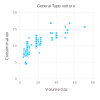

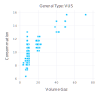

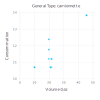

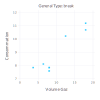

In [18]:
plots = []

for general_type in unique(train_data_exploration.general_type)
    data_type = train_data_exploration[train_data_exploration.general_type .== general_type, :]
    push!(plots, plot(
        x=data_type.volume_gaz,
        y=data_type.consommation,
        Geom.point,
        Guide.title("General Type: $general_type"),
        Guide.xlabel("Volume Gaz"),
        Guide.ylabel("Consommation")
    ))
end

set_default_plot_size(10cm, 10cm)

for i in 1:length(plots)
    display(plots[i])
end

Les graphiques ci-dessus semblent montrer une tendance linéaire, où une augmentation du volume de gaz (x) semble être associée à une hausse de la consommation (y). Ainsi, la variable `general_type` pourrait être une variable explicative pertinente pour comprendre la consommation.

### Transformation des variables explicatives: inclusion des variables qualitatives

L'encodage des variables explicatives qualitatives `general_type`, `transmission` et `boite` est essentiel afin d'être en mesure de les transformer en format numérique et de pouvoir les intégrer dans nos modèles pour effectuer la prédiction.

Nous avons décidé de faire un encodage One-Hot Encoding pour représenter chaque catégorie de manière binaire (0 ou 1), ce qui permet de conserver la distinction entre les différentes catégories tout en évitant de leur attribuer une hiérarchie implicite.

La fonction remove_rows a pour but d'enlever les colonnes des variables qualitatives (`type`, `general_type`, `transmission` et `boite`) une fois qu'elles ont été encodées.

In [19]:
function encode(data, column)
    for c in unique(data[!, column])
        data[!, Symbol(c)] = ifelse.(data[!, column] .== c, 1, 0)
    end
    return data
end

function encode_data(data)
    encoded_data = deepcopy(data)
    encoded_data = encode(encoded_data, :general_type)
    encoded_data = encode(encoded_data, :transmission)
    encoded_data = encode(encoded_data, :boite)
    return encoded_data
end

function remove_rows(data)
    return select!(data, Not([:type, :transmission, :boite, :general_type,]))
end

remove_rows (generic function with 1 method)

In [20]:
train_data_exploration_encoded = encode_data(train_data_exploration)
remove_rows(train_data_exploration_encoded)
first(train_data_exploration_encoded, 5)

5×16 DataFrame
 Row │ annee  nombre_cylindres  cylindree  consommation  volume_gaz  weight  v ⋯
     │ Int64  Int64             Float64    Float64       Float64     Int64   I ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  2023                 8        4.4      13.8359         35.2    3300    ⋯
   2 │  2020                 4        2.0       9.80042         8.0    3500
   3 │  2021                 6        3.3      11.7605         19.8    2800
   4 │  2023                 8        5.0      13.0672         40.0    2800
   5 │  2022                 8        4.4      13.8359         35.2    3300    ⋯
                                                              10 columns omitted

### Analyse de colinéarité

La colinéarité survient lorsque deux ou plusieurs variables sont fortement corrélées, ce qui peut causer des problèmes lors de l'ajustement de modèles statistiques ou d'apprentissage automatique. Plus précisément, une forte colinéarité peut :
- Rendre difficile l'interprétation des coefficients dans un modèle.
- Affecter la stabilité numérique des algorithmes de régression.

C'est pourquoi cette analyse est essentielle pour la précision de notre modèle. Pour identifier les variables colinéaires, nous calculons une matrice de corrélation pour les variables numériques et repérons les paires dont la corrélation absolue dépasse un certain seuil (ici 0,8). Ceci nous guidera dans nos décisions futures en face aux variables explicatives.

In [21]:
function evaluate_collinear(data, seuil)
    numerical_data = select(data, findall(x -> eltype(x) <: Number, eachcol(data)))
    
    correlation_matrix = cor(Matrix(numerical_data))
    
    collinear_variables = []
    R² = []
    
    for i in 1:size(correlation_matrix, 1)
        for j in (i + 1):size(correlation_matrix, 2)
            R = abs(correlation_matrix[i, j])
            if R >= seuil
                push!(collinear_variables, (names(numerical_data)[i], names(numerical_data)[j]))
                push!(R², R^2)
            end
        end
    end
    
    return correlation_matrix, collinear_variables, R²
end

evaluate_collinear (generic function with 1 method)

In [22]:
function calculate_vif(R²)
    VIF = (1 / (1 - R²))
    return VIF
end

calculate_vif (generic function with 1 method)

In [23]:
correlation_matrix, collinear_variables, R² = evaluate_collinear(train_data_exploration_encoded, 0.8)

println("Matrice de corrélation :")
println(correlation_matrix)

println("\nPaires de variables susceptibles d'être colinéaires et leurs R² :")
for (paire, R²) in zip(collinear_variables, R²)
    VIF = calculate_vif(R²)
    println("Paire : $paire, VIF : $VIF")
end

Matrice de corrélation :
[1.0 -0.12948282328871585 -0.161566712193638 -0.16432399490671934 -0.13830876904905637 -0.19612997393935774 0.19819795381687705 -0.21774800747727116 0.0181970432442031 0.01713108737412751 0.08587382159474534 -0.08732734035509578 0.04473469647916668 -0.11906654983048105 0.07393673640660979 -0.07393673640660973; -0.12948282328871585 1.0 0.9434377163852762 0.850881980547585 0.9682909292786173 0.16504051159517932 0.17244450307007717 -0.18601143635983067 0.07830725999798853 -0.07339952711064192 0.23263649195922223 0.25806737005537383 -0.49253955417673256 0.07052315645184078 0.21482409430087326 -0.21482409430087324; -0.161566712193638 0.9434377163852762 1.0 0.858511338769442 0.9771792464258108 0.2621398640180924 0.08871429117588586 -0.10798195652277247 0.1186230722466394 -0.09596312059989595 0.1625361990709415 0.2689938888173945 -0.4662127745640942 0.1431919989558235 0.20307130662163958 -0.20307130662163952; -0.16432399490671934 0.850881980547585 0.858511338769442 1.

L'analyse de colinéarité réalisée ci-dessus sur les données a permis de détecter plusieurs paires de variables susceptibles d’être fortement corrélées, notamment `nombre_cylindres`, `cylindree` et `volume_gaz`.En effet, le calcul des `VIF` confirme une très forte colinéarité sur ces trois paramètres (VIF>=10).  Ce qu’on en retire est que ces variables pourraient introduire de la redondance dans les modèles prédictifs, ce qui peut affecter la stabilité et l’interprétabilité des résultats. Étant donné que la variable d'intérêt est la consommation, il serait pertinent de considérer la suppression de certaines de ces variables colinéaires afin de simplifier le modèle et éviter les problèmes liés à la multicolinéarité.

### Données uniques

Nous avons remarqué que, parmi les 396 données, de nombreuses possèdent les mêmes caractéristiques. C'est-à-dire que leurs variables explicatives sont identiques, à l’exception de l’année. Comme mentionné dans l’analyse des graphiques de la section "Recherche de relations entre les variables explicatives et la variable d’intérêt", nous n'avons pas observé de relation entre la consommation et l'année. Ainsi, nous sélectionnons toutes les colonnes de l’ensemble d’entraînement, sauf `année` et `consommation`, afin de regrouper les données ayant des caractéristiques similaires. Nous soutirons l'année, car elle ne semble pas induire beaucoup d'information sur la consommation. C'est une hypothèse que nous validerons ci-bas. L’objectif est ensuite de calculer la moyenne de la consommation pour chaque groupe ainsi formé, puis de former un ensemble ayant que les données uniques. 

Il semble logique d'opter pour la moyenne dans ce cas, pusique pour des X identiques avec des valeurs de y différentes, si notre objectif est de minimiser le RMSE:

$RMSE = \sqrt{\sum_{i = 1}^{n}{(y_i - \hat{y_i})^2}} = ||{y - \hat{y}}||$

si on veut minimiser cette quantié pour une constante $\hat{y}$ tel que $RMSE$ est minimisé

$\frac{\partial}{\partial\hat{y}} \sqrt{\sum_{i = 1}^{n}{(y_i - \hat{y})^2}} = 0$

par la loi de différentiation en chaine:

$ \sqrt{ \frac{\partial}{\partial\hat{y}} \sum_{i = 1}^{n}{(y_i - \hat{y})^2}} * \frac{1}{2 * \sum_{i = 1}^{n}{(y_i - \hat{y})^2}} = 0$

ou bien

$ \sqrt{ \frac{\partial}{\partial\hat{y}} \sum_{i = 1}^{n}{(y_i^2 + \hat{y}^2 - 2 * y_i * \hat{y})}} = 0 $

$ \sqrt{ \frac{\partial}{\partial\hat{y}}( n\hat{y}^2 +  \sum_{i = 1}^{n}{y_i^2} - \sum_{i = 1}^{n}2y_i\hat{y})} = 0 $

$ \sqrt{ 2n\hat{y}  - \sum_{i = 1}^{n}2y_i} = 0 $

$2n\hat{y} = 2\sum_{i = 1}^{n}y_i$

$\hat{y} = \frac{\sum_{i = 1}^{n}y_i}{n} = \bar{y}$

La moyenne est donc l'estimateur qui minimise le RMSE pour nos observations X identiques.

In [24]:
function get_unique_data(data)
    data_without_consommation = select(data, Not(:consommation, :annee))
    unique_data = combine(groupby(data, names(data_without_consommation)), :consommation => mean)
    rename!(unique_data, :consommation_mean => :consommation)
    return unique_data
end

get_unique_data (generic function with 1 method)

In [ ]:
unique_train_data_exploration = get_unique_data(train_data_exploration)

On peut observer que nous avons maintenant 145 données.

Examinons les relations entre la `consommation` et les variables explicatives pour déterminer si des changements significatifs sont observés par rapport aux graphiques présentés dans la section "Recherche de relations entre les variables explicatives et la variable d’intérêt.

In [ ]:
variables = [:type, :nombre_cylindres, :cylindree, :transmission, :boite, :volume_gaz]

plots = [
    Gadfly.plot(
        unique_train_data_exploration,
        x=var,
        y=:consommation,
        Geom.point,
        Guide.xlabel(string(var)),
        Guide.ylabel("consommation")
    ) for var in variables
]

set_default_plot_size(35cm, 35cm)
p = reshape(plots, (3,2))
gridstack(p)

Les graphiques ci-dessus présentent une allure similaire à ceux de la section "Recherche de relations entre les variables explicatives et la variable d’intérêt". Cela dit, il pourrait être intéressant de tester avec les modèles en ne conservant que les données uniques. Cette approche permet de simplifier le dataset en réduisant la redondance des observations ayant les mêmes caractéristiques explicatives. Cela pourrait faciliter l’apprentissage du modèle tout en améliorant son efficacité et en limitant les risques d'erreurs liés à des consommations différentes pour des données identiques.

### Analyse des données aberrantes

Pour l'analyse des données aberrantes, nous avons commencé par faire la ségrégation des données aberrantes à l'aide de la méthode classique des quantiles sur le graphique de la `cylindree` en fonction de la `consommation`.

In [27]:
function compute_outliers(column)
    Q1 = quantile(column, 0.25)
    Q3 = quantile(column, 0.75) 
    IQR = Q3 - Q1                
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    println("Column bounds -> Lower: ", lower_bound, ", Upper: ", upper_bound, ", Q1: ", Q1, ", Q3: ", Q3, ", IQR: ", IQR)
    return findall(x -> x < lower_bound || x > upper_bound, column)
end

compute_outliers (generic function with 1 method)

In [28]:
function get_outliers_ind_quantile(data, x_col, y_col)
    x = data[!, x_col]
    y = data[!, y_col]

    outlier_indices_x = compute_outliers(x)
    outlier_indices_y = compute_outliers(y)

    combined_outlier_indices = vcat(outlier_indices_x, outlier_indices_y)
    return combined_outlier_indices
end

get_outliers_ind_quantile (generic function with 1 method)

In [29]:
function get_outliers(data, outliers_indices)
    outliers = data[outliers_indices, :]
    return outliers
end;

Cette fonction affiche un graphique de la `consommation` en fonction de la `cylindree`. Les données aberrantes y sont affichées en noir.

In [30]:
function plot_outliers_quantile(unique_data)
    outliers_indices = get_outliers_ind_quantile(unique_data, :cylindree, :consommation)
    outliers_quantile = get_outliers(unique_data, outliers_indices)
   
    layer_original = layer(x=unique_data.cylindree, y=unique_data.consommation, color=unique_data.type)
    layer_quantile_outliers = layer(x=outliers_quantile.cylindree, y=outliers_quantile.consommation, Theme(default_color="black"))
    set_default_plot_size(15cm, 15cm)
    
    display(plot(layer_quantile_outliers, layer_original, Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Original Data with Outliers")))
end

plot_outliers_quantile (generic function with 1 method)

Column bounds -> Lower: -0.40000000000000036, Upper: 6.0, Q1: 2.0, Q3: 3.6, IQR: 1.6
Column bounds -> Lower: 4.137953703703698, Upper: 16.33402777777778, Q1: 8.71148148148148, Q3: 11.7605, IQR: 3.049018518518521


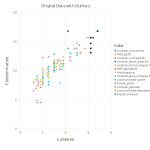

In [31]:
plot_outliers_quantile(unique_train_data_exploration)

Les résultats étant trop stricts sur les types plus consommateurs, nous avons plutôt opté pour une régression linéaire avec un seuil choisi. Ce choix de régression linéaire a été fait, car comme vu ci-dessus, suit une tendance linéaire. On commence par trouver les indices (lignes) des données aberrantes avec les méthodes "get_outliers_ind_regression_lin" et "linear_regression":

In [32]:
function get_outliers_ind_regression_lin(data, x_col, y_col; threshold=2.5)
    slope, intercept = linear_regression(data, x_col, y_col)
    
    x = data[!, x_col]
    y = data[!, y_col]
    
    y_pred = slope .* x .+ intercept
    
    residuals = abs.(y .- y_pred)
    
    residuals_std = std(residuals)
    
    outlier_indices = findall(residuals .> threshold * residuals_std)
    
    outliers = data[outlier_indices, :]
    
    return outlier_indices
end

get_outliers_ind_regression_lin (generic function with 1 method)

In [33]:
function linear_regression(data, x_col, y_col)
    x = data[!, x_col]
    y = data[!, y_col]
    
    n = length(x)
    if n == 0
        error("Cannot compute linear regression with zero elements.")
    end
    
    x̄ = mean(x)
    ȳ = mean(y)
    
    slope = sum((x .- x̄) .* (y .- ȳ)) / sum((x .- x̄).^2)
    intercept = ȳ - slope * x̄
    
    return slope, intercept
end

linear_regression (generic function with 1 method)

De plus, une fonction pour enlever des données aberrantes (remove_outliers_regression_lin):

In [34]:
function remove_outliers_regression_lin(data::DataFrame, x_col::Symbol, y_col::Symbol; threshold=2.5)
    outlier_indices = get_outliers_ind_regression_lin(data, x_col, y_col, threshold=threshold)

    keep_mask = trues(nrow(data))
    
    if !isempty(outlier_indices)
        keep_mask[outlier_indices] .= false
    end

    cleaned_data = data[keep_mask, :]
    
    return cleaned_data
end

remove_outliers_regression_lin (generic function with 1 method)

Dernièrement, une fonction pour visualiser les données avant (points noirs) et après le retrait des données aberrantes (plot_outliers):

In [35]:

function plot_outliers(unique_data)
    outliers_indices = get_outliers_ind_regression_lin(unique_data, :cylindree, :consommation)
    outliers_regression = get_outliers(unique_data, outliers_indices)
   
    slope, intercept = linear_regression(unique_data, :cylindree, :consommation)
    regression_line_y = slope .* unique_data.cylindree .+ intercept
   
    layer_original = layer(x=unique_data.cylindree, y=unique_data.consommation, color=unique_data.type)
    layer_linear_regression = layer(x=unique_data.cylindree, y=regression_line_y, Geom.line, Theme(default_color="green"))
    layer_regression_outliers = layer(x=outliers_regression.cylindree, y=outliers_regression.consommation, Geom.point, Theme(default_color="black"))
    set_default_plot_size(15cm, 15cm)
    
    display(plot(layer_regression_outliers, layer_original, layer_linear_regression, Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Original Data with Outliers")))
   
    cleaned_data = remove_outliers_regression_lin(unique_data, :cylindree, :consommation, threshold=2.5)
   
    slope_cleaned, intercept_cleaned = linear_regression(cleaned_data, :cylindree, :consommation)
    regression_line_y_cleaned = slope_cleaned .* cleaned_data.cylindree .+ intercept_cleaned
   
   layer_cleaned = layer(x=cleaned_data.cylindree, y=cleaned_data.consommation, color=cleaned_data.type, Theme(default_color="blue"))
   layer_linear_regression_cleaned = layer(x=cleaned_data.cylindree, y=regression_line_y_cleaned, Geom.line, Theme(default_color="green"))
   
   display(plot(layer_cleaned, layer_linear_regression_cleaned, 
                Guide.xlabel("Cylindree"), Guide.ylabel("Consommation"), Guide.title("Cleaned Data with Regression Line")))
   
end

plot_outliers (generic function with 1 method)

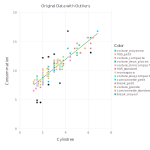

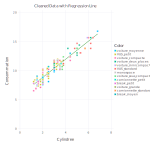

In [36]:
plot_outliers(unique_train_data_exploration)

Cette analyse et ségrégation des données aberrantes pourront nous être utile plus tard dans nos recherches.

## Préparation des données

### Standardisation des données

Nous avons standardisé les données numériques pour mettre toutes nos données sur la même échelle. De cette façon, on peut comparer leur importance relative. De plus, une variable ayant des valeurs très hautes comparées aux autres n'influencera pas les données de façon plus significative qu'elle le devrait.

Nous créons des constantes pour pouvoir mettre les données à la bonne échelle après nos prédictions.

In [37]:
COMSOMMATION_MEAN = mean(train_data.consommation)
COMSOMMATION_STD = std(train_data.consommation)

2.139763088813657

Ces fonctions permettent de standardiser toutes les données numériques sauf l'id.

In [38]:
function standardize(data)
    return (data .- mean(data)) ./ std(data)
end

function standardize_data(data)
    std_data = deepcopy(data)
   for col in names(std_data)
        if eltype(std_data[!, col]) <: Number && col != "id"
            std_data[!, col] = standardize(std_data[!, col])
        end
    end
    return std_data
end

standardize_data (generic function with 1 method)

### Ajout de variables explicatives

Nous ajoutons les variables `volume_gaz`, `weight`, et `general_type` aux variables explicatives.

In [39]:
function add_rows(data)
    add_volume_gaz(data)
    add_weight(data)
    add_general_type(data)
    return data
end

add_rows (generic function with 1 method)

### Données préparées

Cette fonction permet de préparer les données avec toutes les fonctions que nous avons définies précédemment.

In [40]:
function get_standard_encoded_data(data)
    data_copy = deepcopy(data)
    standardised_data = get_unique_data(data_copy)
    standardised_data = add_rows(data_copy)
    standardised_data = standardize_data(data_copy)
    standardised_data = encode_data(standardised_data)
    standardised_data = remove_rows(standardised_data)
    
    return standardised_data
end

get_standard_encoded_data (generic function with 1 method)

## Évaluation des modèles

### Calcul  du RMSE

Nous avons évalué nos modèles avec la métrique RMSE, car c'est celle-ci qui est utilisée pour évaluer nos prédictions dans le concours.

In [41]:
function rmse(y, prediction)
    return sqrt(mean((prediction .- y).^2))
end

rmse (generic function with 1 method)

Nous avons calculé le RMSE moyen en faisant une séparation aléatoire des données à chaque fois afin d'avoir une idée générale du RMSE de chaque modèle.

In [42]:
function evaluate_rmse(data, model, nrange = 1000, test_size = 0.2, param = 0.0, should_print = true)
    n = 0
    for i in range(0, 1, length=nrange)
        train_data, test_data = train_test_split(data, test_size)
        if (param == 0.0)
            n += model(train_data, test_data)[1]
        else
        n += model(train_data, test_data, param)[1]
        end
    end
    average_rmse = n/nrange
    if should_print
        print("average rmse: ", average_rmse, "\n")
    end
    return average_rmse
end

evaluate_rmse (generic function with 5 methods)

### Séparation des ensembles d'entrainement et de validation

Nous avons effectué les tests sur nos modèles en prenant soin de séparé les données en ensemble d'entraînement et en ensemble de test. Par défaut, nos données sont séparées 80% dans l'ensemble d'entraînement et 20% dans l'ensemble de test.

In [43]:
function train_test_split(data, test_size=0.2, shuffle=true)
    n = size(data, 1)
    test_size = floor(Int, n * test_size)
    
    if shuffle
        indices = randperm(n)
    else
        indices = 1:n
    end
    
    test_indices = indices[1:test_size]
    train_indices = indices[test_size+1:end]
    
    train_data = data[train_indices, :]
    test_data = data[test_indices, :]
    
    return train_data, test_data
end

train_test_split (generic function with 3 methods)

### Les différents modèles

Voici une liste des tous les modèles prédictifs que nous avons implémentés et tester afin d'obtenir les meilleures prédictions de consommation d'essence:
- Régression linéaire
- Régression ridge
- Régression SVD
- Régression polynomiale
- Arbres de régression
- Forêt aléatoire de régression

Voici leurs implémentations:

#### Régression linéaire

Le premier modèle que nous avons implémenté est la régression linéaire. Ce modèle nous semblait intuitif, car les données explicatives `cylindree`, `nombre_cylindres` et `volume_gaz` semblent suivre une relation linéaire.

In [44]:
function regression(training_data, test_data = nothing)	
    X_train =  Matrix(training_data[:, Not(:consommation, :id)])
    y_train = training_data[:, :consommation]

    𝛽 = X_train \ y_train

    rmse_val = 0.0
    if test_data != nothing
        X_test = Matrix(test_data[:, Not(:consommation, :id)])
        y_test = test_data[:, :consommation]
        𝒚̂ =  X_test * 𝛽
        𝒚̂ = (𝒚̂ .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        y_test = (y_test .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        rmse_val = rmse(y_test, 𝒚̂)
    end
    
    return rmse_val, 𝛽
end

regression (generic function with 2 methods)

In [45]:
evaluate_rmse(get_standard_encoded_data(train_data), regression)


average rmse: 0.9511094457913212


0.9511094457913212

On peut voir que le RMSE moyen obtenu est relativement bas. Le modèle a donc du potentiel et pourrait peut-être être amélioré. Cependant, lorsque nous avons fait une remise officielle sur Kaggle, notre résultat a été nettement supérieur. On peut donc penser que le modèle ne prend pas en compte les données extrêmes et les tendances différentes avec des combinaisons de données spécifiques. On peut donc conclure que la régression linéaire n'est pas la meilleure méthode pour prédire la consommation d'essence.

#### Régression ridge

Le deuxième modèle que nous avons implémenté est la régression ridge. Ce modèle permet de réduire l'importance de la colinéarité entre les données et ainsi réduire la variance du modèle. Cependant, cela introduit un biais dans le modèle. En atteignant un équilibre entre le biais introduit et la diminution de la variance, il est possible de minimiser le RMSE. 

In [46]:
function ridge_regression(training_data, test_data = nothing, 𝜆=0.5)
    X_train = Matrix(training_data[:, Not([:consommation, :id])])
    y_train = training_data[:, :consommation]
    𝛽 = (X_train'X_train + 𝜆*I)\X_train'y_train

    rmse_val = 0.0
    if test_data != nothing
        X_test = Matrix(test_data[:, Not(:consommation, :id)])
        y_test = test_data[:, :consommation]
        𝒚̂ =  X_test * 𝛽
        𝒚̂ = (𝒚̂ .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        y_test = (y_test .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        rmse_val = rmse(y_test, 𝒚̂)
    end
    return rmse_val, 𝛽
end

ridge_regression (generic function with 3 methods)

On effectue le calcul du RMSE avec plusieurs lambdas différents afin de trouver le meilleur lambda possible.

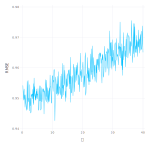

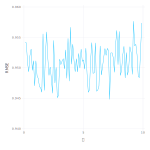

meilleur 𝜆: 10.8
rmse correspondant: 0.942614671874902


In [47]:
rmse_data = DataFrame(𝜆=Float64[], rmse=Float64[])
for i in 0.1:0.1:40.0
    rmse_val = evaluate_rmse(get_standard_encoded_data(train_data), ridge_regression, 1000, 0.2, i, false)
    push!(rmse_data, (i, rmse_val))
end
display(plot(rmse_data, x=:𝜆, y=:rmse, Geom.line, Guide.xlabel("𝜆"), Guide.ylabel("RMSE")))

filtered_rmse_data = filter(row -> row[:𝜆] < 10, rmse_data)
display(plot(filtered_rmse_data, x=:𝜆, y=:rmse, Geom.line, Guide.xlabel("𝜆"), Guide.ylabel("RMSE")))

best_row = rmse_data[argmin(rmse_data.rmse),:]
println("meilleur 𝜆: ", best_row.𝜆)
println("rmse correspondant: ", best_row.rmse)

On peut voir qu'il y a beaucoup de variation dans la valeur de RMSE selon la valeur de lambda. Cette variation est causé en partie par la manière aléatoire avec laquelle les données sont séparées en ensemble d'entraînement et de test. On voit toutefois une tendance à la hausse lorsque lambda dépasse 10. On a donc fait un deuxième graphique pour mieux voir les données entre 0.1 et 10. On a ensuite trouvé la valeur de lambda qui donne le meilleur RMSE. Ce RMSE est comparable à celui de la régression linéaire. La régression ridge souffre des mêmes problèmes que la régression linéaire. On peut donc conclure que la régression ridge n'est pas la meilleure méthode pour prédire la consommation d'essence.

#### Régression SVD

Le troisième modèle que nous avons implémenté est la régression SVD. Ce modèle permet de décerner s'il peut y avoir des variables et des relations entre les variables latentes qui peuvent améliorer nos prédictions.

In [48]:
function svd_regression(training_data, test_data = nothing)
    X_train = Matrix(training_data[:, Not([:consommation, :id])])
    y_train = training_data[:, :consommation]
    
    U, S, V = svd(X_train)

    𝛽 = V' * Diagonal([s > 1e-10 ? 1/s : 0 for s in S]) * U' * y_train

    rmseval = 0.0
    if test_data != nothing
        X_test = Matrix(test_data[:, Not(:consommation,:id)])
        y_test = test_data[:, :consommation]
        𝒚̂ =  X_test * 𝛽
        𝒚̂ = (𝒚̂ .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        y_test = (y_test .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        rmseval = rmse(y_test, 𝒚̂)
    end
    return rmseval, 𝛽
end

svd_regression (generic function with 2 methods)

In [49]:
evaluate_rmse(get_standard_encoded_data(train_data), svd_regression)

average rmse: 2.453091962122858


2.453091962122858

On remarque que le modèle de régression SVD obtient un RMSE très élevé. Avec les données que nous avons, il semble que le modèle de régression SVD surcomplexifie le modèle et donc nuit aux résultats. On peut donc conclure que la régression SVD n'est pas la meilleure méthode pour prédire la `consommation` d'essence.

#### Régression polynomiale

Le quatrième modèle que nous avons implémenté est la régression polynomiale. Ce modèle permet de modéliser des relations non linéaires ce qui augmente la flexibilité du modèle et permet d'obtenir une meilleure approximation des données lorsque les relations linéaires ne suffisent pas (hypothèse que l'on pourra confirmer ou rejeter). Cependant, pour éviter le surapprentissage induit par un degré trop élevé, nous avons ajusté le degré du polynôme afin de trouver un équilibre optimal entre biais et variance, et dans notre cas, `degree = 3` minimise le RMSE.

In [50]:
function construct_structure(x::Matrix{<:Real}, order::Int)
    n, m = size(x)
    poly_terms = [x[:, j].^p for j in 1:m, p in 0:order]
    X = hcat(poly_terms...)
    return X
end

function polynomial_regression(training_data, test_data = nothing, degree = 3)
    X_train = construct_structure(Matrix(training_data[:, Not([:consommation, :id])]), degree)
    y_train = training_data[:, :consommation]

    𝛽 = X_train \ y_train

    rmse_value = 0.0

    if test_data != nothing
        X_test = construct_structure(Matrix(test_data[:, Not([:consommation, :id])]), degree)
        y_test = test_data[:, :consommation]
        𝒚̂ = X_test * 𝛽
        𝒚̂ = (𝒚̂ .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
        y_test = (y_test .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN

        rmse_value = rmse(y_test, 𝒚̂)
    end

    return rmse_value, 𝛽
end

polynomial_regression (generic function with 3 methods)

In [51]:
evaluate_rmse(get_standard_encoded_data(train_data), polynomial_regression)

average rmse: 0.9142443388341419


0.9142443388341419

Le RMSE moyen obtenu avec la régression polynomiale est de 0.911, ce qui indique un modèle relativement performant sur les données de validation. Cependant, lors de la soumission officielle sur Kaggle, le RMSE obtenu était significativement plus élevé, suggérant que le modèle n’est pas capable de généraliser correctement sur des données non vues. On peut donc penser que le modèle ne prend pas en compte les données extrêmes et les tendances différentes avec des combinaisons de données spécifiques ou même qu'il suit un modèle plus linéaire. On peut donc conclure que la régression polynomiale n'est pas la meilleure méthode pour prédire la `consommation` d'essence.

#### Arbre de régression

Le cinquième modèle que nous avons implémenté est un arbre de régression. Ce modèle permet d'effectuer des séparations dans l'ensemble d'entraînement afin de discerner des liens entre certaines variables et d'ainsi mieux prédire les cas extrêmes et les combinaisons de données spécifiques. Ce modèle tente donc de pallier aux problèmes des modèles linéaire, ridge et polynomial.

In [53]:
function tree_regression(training_data, test_data = nothing)
    X_train = Matrix(training_data[:, Not(:consommation, :id)])
    y_train = training_data.consommation
    X_test = Matrix(test_data[:, Not(:consommation,:id)])
    y_test = test_data.consommation

    model = DecisionTreeRegressor(max_depth=5)
    fit!(model, X_train, y_train)
    ŷ =  predict(model, X_test)  

    ŷ = (ŷ .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    y_test = (y_test .* COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    rmseval = rmse(y_test, ŷ)

end

tree_regression (generic function with 2 methods)

In [54]:
evaluate_rmse(get_standard_encoded_data(train_data), tree_regression)

average rmse: 0.939695554487921


0.939695554487921

On remarque que le résultat est similaire à ceux des modèles linéaire, ridge et polynomiale. Cela peut être expliqué par le fait qu'un arbre de régression comporte généralement une assez grande variance. De plus, si certaines données n'ont pas de donnée similaire dans l'ensemble d'entraînement, celles-ci peuvent être très difficiles à prédire. Ce modèle pourrait donc être amélioré.

#### Forêt aléatoire de régression

Le sixième modèle que nous avons implémenté est une forêt aléatoire de régression. Ce modèle utilise plusieurs arbres de régression afin de pallier aux problèmes engendrés par le fait d'utiliser un seul arbre de régression. Ce modèle devrait donc améliorer les résultats du modèle précédent.

In [56]:
function random_forest(training_data, test_data = nothing)
    X_train =  Matrix(training_data[:, Not(:consommation, :id)])
    y_train = training_data.consommation
    X_test = Matrix(test_data[:, Not(:consommation, :id)])
    y_test = test_data.consommation


    model = RandomForestRegressor(n_subfeatures=12, n_trees=1000,min_samples_leaf=1,min_purity_increase=0.0, max_depth=5, min_samples_split=6)
    DecisionTree.fit!(model, X_train, y_train)
    ŷ = DecisionTree.predict(model, X_test)
    y_test = (y_test * COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    ŷ = (ŷ * COMSOMMATION_STD) .+ COMSOMMATION_MEAN
    return rmse(y_test, ŷ)
end

random_forest (generic function with 2 methods)

In [57]:
evaluate_rmse(get_standard_encoded_data(train_data), random_forest, 100)

average rmse: 0.8709004559405994


0.8709004559405994

On voit donc que le RMSE moyen obtenu est inférieur à celui de tous les modèles précédents. Ce modèle a donc du potentiel et pourrait être amélioré. Cependant, lorsque nous avons fait une remise officielle sur Kaggle, notre résultat a été nettement supérieur. Il y a donc potentiellement des combinaisons de données qui ne se retrouvent pas dans les données d'entraînement. C'est une des faiblesses du modèle de forêt aléatoire de régression. On peut donc conclure que la forêt aléatoire de régression n'est pas la meilleure méthode pour prédire la consommation d'essence.

#### Comparaison des modèles

Tous les modèles, à l'exception de la régression SVD qui est nettement pire, ont un RMSE moyen relativement semblable et comportent tous des défauts. Bien que l'écart soit petit, le modèle forêt aléatoire de régression a obtenu le meilleur résultat. 

Chacun de ces modèles n'a pas performé à la hauteur des résultats attendus lors de nos remises sur Kaggle. Il faut donc apporter des modifications afin de les rendre meilleurs pour prédire des données qui ne sont pas dans l'ensemble d'entraînement.

Nous avons décidé d'implémenter un modèle utilisant en partie la forêt de régression afin de faire notre remise finale. 

## Modèle sélectionné

Suite à notre analyse des données et des modèles potentiels, nous avons remarqué deux tendances importantes. Premièrement, dans les données du fichier de test à prédire, la grande majorité d'entre elles sont également présentes tel quel dans le fichier de données d'entrainement (voir ci-bas). Il en suit donc que nous pouvons utiliser une estimation ponctuelle très simple, tel qu'expliqué dans la section «Estimation des paires». Deuxièmement, la forêt aléatoire de régression nous a permis d'obtenir les meilleurs résultats parmi les modèles potentiels, nous l'intégrerons donc dans notre solution (voir la section «Forêt aléatoire de régression»). 

#### Préparation des données pour la prédiction

Nous apportons quelques modifications aux données basées sur des tendances que nous avons remarquées grâce à l'analyse exploratoire des données. 

Nous avons changé le type des données d'entrainement lorsque celui-ci est break_petit afin de réunir break_petit et break_moyen comme on le faisait avec les types généraux.

Nous avons modifié le type des données à prédire lorsque celles-ci sont break_moyen ou camionnette_standard, car ces types comportent une seule donnée chacun dans l'ensemble d'entraînement. De cette façon, ces types n'ont pas d'influence sur les prédictions, mais leurs données sont conservées. Cette aberrance est également reflétée par le fait que leur coefficient dans la régression ridge est un ordre de magnitude plus bas que toutes les autres variables explicatives.

Nous avons retiré les données du type monospace, car celles-ci semblent être aberrantes lorsqu'on regarde la tendance de la consommation par rapport au volume_gaz comparée à celle de tous les autres types. C'est une tendance décroissante alors que tous les autres types ont une croissance croissante.

Nous avons créé un nouveau type correspondant aux voiture_deux_places manuelles intégrales et ayant plus de 8 cylindres. Nous avons remarqué que cette combinaison possède une consommation nettement supérieure aux combinaisons semblables, mais ayant une variable différente. Nous croyons que cette combinaison correspond aux voitures sport qui consomment beaucoup plus et qui comprennent souvent ces caractéristiques. Ceci consiste à nos yeux une variable latente qui, lorsqu’incluse, améliore nettement nos résultats.

In [58]:
function prepare_data_for_prediction(train_data, test_data)
    train_data.type = ifelse.(train_data.type .== "break_petit", "break_moyen", train_data.type)
    test_data.type = ifelse.(test_data.type .== "break_moyen", "break", test_data.type)
    
    test_data.type = ifelse.(test_data.type .== "camionnette_standard", "cam", test_data.type)
    
    train_data = filter(row -> row.type != "monospace", train_data)
    train_data.type = ifelse.(train_data.type .== "voiture_deux_places" .&& train_data.nombre_cylindres .>= 8 .&& train_data.boite .== "manuelle" .&& train_data.transmission .== "integrale", "voiture_sport", train_data.type)
    test_data.type = ifelse.(test_data.type .== "voiture_deux_places" .&& test_data.nombre_cylindres .>= 8 .&& test_data.boite .== "manuelle" .&& test_data.transmission .== "integrale", "voiture_sport", test_data.type)
    return train_data, test_data
end

prepare_data_for_prediction (generic function with 1 method)

### Forêt aléatoire de régression


La première composante de notre modèle est une forêt de régression. Nous avons utilisé l'implémentation de la librairie "DecisionTree". La forêt utilise les paramètres suivants, que nous avons identifiés en utilisant un algorithme de "Grid Search":

- n_subfeatures=5, 
- n_trees=1000,
- min_samples_leaf=1,
- min_purity_increase=0.0, 
- max_depth=5, 
- min_samples_split=6

Chaque arbre fonctionne en partitionnant l'espace des données d'entrainement en zones d'entropie minimale, ce qui lui permet de faire des prédictions par la suite. 

Pour empêcher des situations de surentrainement, nous nous sommes assurés de garder l'hyperparamètre `depth` à 5, pour éviter que notre modèle apprenne des tendances qui ne sont présentes que dans le fichier `train.csv`, ce qui se généraliserait mal au reste des données. 

In [59]:
function forest_regression(training_data, test_data)
    ids = test_data.id

    y_train = training_data.consommation
    common_columns = intersect(names(training_data), names(test_data))
    training_data = training_data[:, common_columns]
    test_data = test_data[:, common_columns]

    X_train = Matrix(training_data[:, Not(:annee, :id)])
    X_test = Matrix(test_data[:, Not(:annee, :id)])

    model = RandomForestRegressor(n_subfeatures=5, n_trees=1000,min_samples_leaf=1,min_purity_increase=0.0, max_depth=5, min_samples_split=6)
    fit!(model, X_train, y_train)
    ŷ =  predict(model, X_test)  

    prediction = DataFrame(id=ids, consommation=ŷ)

    return prediction    
end

forest_regression (generic function with 1 method)

### Estimation des paires

Comme vu plus haut, l'intersection entre les données d'entrainement et de validation est assez grande. On peut donc faire une estimation ponctuelle en utilisant la moyenne des consommations des rangées identiques dans l'ensemble d'entrainement. Comme nous l'avons démontré ci-dessus, la moyenne est l'estimateur qui minimise le RMSE dans notre cas. 

**Quantification de l'importance des variables explicatives grâce à la régression ridge**

Grâce à la régression ridge, on peut quantifier l'importance de chacune de nos variables explicatives, sachant qu'elles sont toutes normalisées ($y' = \frac{y - \bar{y}}{{\sigma}_y} $). Le coefficient trouvé pour chacune des variables explicatives sera utilisé plus tard pour savoir quels sont les facteurs qui influent le plus sur la consommation. Cette normalisation a également l'effet de retirer le facteur ${\beta}_0$, nous permettant d'interpréter clairement chacun des coefficients.

On obtient les résultats suivants pour les variables explicatives:

In [60]:

train_for_beta = (train_data)
train_for_beta = encode(train_for_beta, :type)
train_for_beta = encode(train_for_beta, :transmission)
train_for_beta = encode(train_for_beta, :boite)
train_for_beta_encoded = train_for_beta[:, Not( :type, :transmission, :boite)]
train_for_beta_encoded
_ , 𝛽 = ridge_regression(train_for_beta_encoded)



𝛽_data_frame = DataFrame(colnames=names(train_for_beta_encoded[:, Not(:id, :consommation)]), 𝛽=𝛽, abs=abs.(𝛽))

sort(𝛽_data_frame, :abs, rev=true)


22×3 DataFrame
 Row │ colnames               𝛽            abs        
     │ String                 Float64      Float64    
─────┼────────────────────────────────────────────────
   1 │ monospace               0.788686    0.788686
   2 │ traction               -0.757944    0.757944
   3 │ cylindree               0.742483    0.742483
   4 │ voiture_moyenne        -0.620328    0.620328
   5 │ VUS_standard            0.513915    0.513915
   6 │ nombre_cylindres        0.445033    0.445033
   7 │ integrale               0.428134    0.428134
   8 │ camionnette_petit       0.376356    0.376356
   9 │ voiture_compacte       -0.336054    0.336054
  10 │ break_petit            -0.314565    0.314565
  11 │ VUS_petit               0.312117    0.312117
  12 │ manuelle                0.287175    0.287175
  13 │ voiture_sous_compacte  -0.256905    0.256905
  14 │ automatique            -0.25667     0.25667
  15 │ voiture_grande         -0.212331    0.212331
  16 │ 4x4                     0.201934    0.201934
  17 │ propulsion              0.158381    0.158381
  18 │ voiture_minicompacte   -0.152184    0.152184
  19 │ voiture_deux_places    -0.0852425   0.0852425
  20 │ break_moyen             0.0107862   0.0107862
  21 │ camionnette_standard    0.0062543   0.0062543
  22 │ annee                   0.00302732  0.00302732

En les regroupants, on peut voir quelles colonnes retirer en ordre croissant.

In [61]:
colonne_a_attribut = Dict("cylindree" => "cylindree", "nombre_cylindres" => "nombre_cylindres", "volume_gaz" => "volume_gaz", "weight" => "weight", "voiture_compacte" => "type", "VUS_petit" => "type", "voiture_sport" => "type", "camionnette" => "type", "break_moyen" => "type", "manuelle" => "boite", "automatique" => "boite", "integrale" => "transmission", "traction" => "transmission", "propulsion" => "transmission", "4x4" => "transmission", "annee" => "annee", "voiture_moyenne" => "type", "voiture_deux_places" => "type", "voiture_minicompacte" => "type", "VUS_standard" => "type", "monospace" => "type","voiture_sous_compacte" => "type", "camionnette_petit" => "type", "break_petit" =>"type", "voiture_grande" => "type", "camionnette_standard" => "type" )

𝛽_data_frame.colType = [colonne_a_attribut[c] for c in 𝛽_data_frame.colnames]
𝛽_data_frame
combined_𝛽 = combine(groupby(𝛽_data_frame, :colType), :abs => mean)

sort(combined_𝛽, :abs_mean, rev=true)

6×2 DataFrame
 Row │ colType           abs_mean   
     │ String            Float64    
─────┼──────────────────────────────
   1 │ cylindree         0.742483
   2 │ nombre_cylindres  0.445033
   3 │ transmission      0.386598
   4 │ type              0.306594
   5 │ boite             0.271922
   6 │ annee             0.00302732

In [62]:
function get_unique_data_by_column(data, columns_to_compare)
    unique_data = combine(groupby(data, columns_to_compare), :consommation => mean)
    rename!(unique_data, :consommation_mean => :consommation)
   return unique_data
end

get_unique_data_by_column (generic function with 1 method)

Cette fonction permet de trouver les valeurs identiques dans l'ensemble d'entraînement et dans l'ensemble de prédiction.

In [63]:
function find_pairs(data_train, data_predict, columns_to_compare)
    common_values = innerjoin(data_train, data_predict, on=columns_to_compare)
    return common_values
end

find_pairs (generic function with 1 method)

L'algorithme se résume comme suit:

1. Trouver le plus de paires possible entre les données comprises dans l'ensemble de test et celles de l'ensemble de train. Utiliser la moyenne des consommations dans l'ensemble d'entrainement comme consommation de cette rangée. 

2. Retirer des ensembles la colonne qui apporte le moins d'information (estimé par le coefficient de ridge ci-bas), augmentant ainsi le nombre de paires.

3. Répéter les étapes ci-haut, jusqu'à ce que plus aucune paire ne puisse être formée.

Après avoir suivi ces étapes, s'il reste encore des points de données qui ne peuvent être prédit, car ils ne forment pas de paires avec l'ensemble d'entrainement, on donne à la forêt de régression l'entierté du poids décisionnel.



In [64]:
COLUMNS_TO_COMPARE_1 = ["type", "nombre_cylindres", "cylindree", "transmission", "boite"]
COLUMNS_TO_COMPARE_2 = ["nombre_cylindres", "cylindree", "type" ]
COLUMNS_TO_COMPARE_3 = ["nombre_cylindres", "cylindree"]

function match_predictions(train_data, data_to_predict, pairs, columns_to_compare)
    unique_data = get_unique_data_by_column(train_data, columns_to_compare)
    new_pairs = find_pairs(unique_data, data_to_predict, columns_to_compare)
    new_pairs = select(new_pairs, [:id, :consommation])
    pairs = vcat(pairs, new_pairs)
    data_to_predict = filter(row -> !(row.id in pairs.id), data_to_predict)
    return pairs, data_to_predict
end

match_predictions (generic function with 1 method)

### Modèle combiné

Afin de minimiser la susceptibilité de notre modèle à produire des valeurs extrêmes, on utilise ces deux méthodes, qui votent tous deux sur la valeur à prédire. On considère les deux modèles comme ayant un poids décisionnel égal. On prend donc la moyenne des deux prédictions comme valeur de prédiction finale. Nous nous sommes inspirés des modèles MOE (mixture of experts), qui sont courants dans le domaine des LLM, qui utilisent plusieurs modèles qui votent sur la meilleure réponse.

In [65]:
function get_predictions(data_train, data_test)
    pairs = DataFrame(id=Int[], consommation=Float64[])
    pairs, data_test = match_predictions(data_train, data_test, pairs, COLUMNS_TO_COMPARE_1)

    data_to_predict_by_forest = deepcopy(data_test)
    perfect_match_pairs = deepcopy(pairs)

    pairs, data_test = match_predictions(data_train, data_test, pairs, COLUMNS_TO_COMPARE_2)
    pairs, data_test = match_predictions(data_train, data_test, pairs, COLUMNS_TO_COMPARE_3)

    ids_with_no_match = data_test.id

    forest_predictions = forest_regression(data_train, data_to_predict_by_forest)

    no_match_predictions = forest_predictions[forest_predictions.id .== ids_with_no_match, :]

    matching_predictions = vcat(pairs, no_match_predictions)
    sort!(matching_predictions, :id)

    forest_predictions = vcat(perfect_match_pairs, forest_predictions)
    sort!(forest_predictions, :id)

    average_predictions = (matching_predictions.consommation .+ forest_predictions.consommation) ./ 2

    average_predictions = DataFrame(id=1:150, consommation=average_predictions)

    return average_predictions
end

get_predictions (generic function with 1 method)

In [66]:
function format_file(predictions,i)
    file_name = "benchmark_$i.csv"
    CSV.write("./" *file_name, predictions)
end

format_file (generic function with 1 method)

In [ ]:
function main(train_data, test_data)
    train_data, test_data = prepare_data_for_prediction(train_data, test_data)
    predictions = get_predictions(train_data, test_data)
    format_file(predictions, 1)
    return predictions
end

main(train_data, test_data)

## Conclusion et amélioration

En conclusion, nous avons procédé à plusieurs étapes d'analyse des données et des différents modèles afin de pouvoir prédire la consommation en carburant de plusieurs véhicules. Nous avons commencé par faire une exploration des données afin de trouver des tendances entre les variables explicatives et la variable d'intérêt. Nous avons ensuite évalué différents modèles de prédictions sur la base du RMSE avant d'en définir un nouveau basé sur les informations que notre analyse nous a appris. Ce modèle a permis d'obtenir un RMSE de 0.78455 sur Kaggle.

Nous avons identifié plusieurs pistes intéressantes pour des amélioration potentielles:

- L’utilisation d'une approche bayésienne aurait pu permettre d'améliorer nos estimations grâce à l'intégration de connaissances a priori. Avec un jeu de données plus vaste, nous aurions pu utiliser cette méthode pour déterminer une loi a posteriori robuste, mieux adaptée aux caractéristiques des données. Cependant, dans ce concours, nous disposions de 396 données. Ce nombre limité de données était insuffisant pour cette approche, car une méthode bayésienne nécessite un grand volume de données pour construire des lois a posteriori fiables et garantir que le modèle puisse apprendre de manière adéquate. 
- Il aurait été bien d’essayer les mélanges de lois en prenant un modèle par combinaison de `type`, de `boite` et de `transmission`. Cependant, la performance des mélanges de lois dépend fortement de la quantité et de la diversité des données disponibles. Dans notre cas, certaines variables avaient très peu de données. Avec un volume de données plus important, nous aurions pu mieux représenter les interactions entre les variables et renforcé la précision de nos prédictions.